In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
ratings_df = pd.read_csv("book-data/ratings.csv")
books_df = pd.read_csv("book-data/books.csv")

In [3]:
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(981756, 3)
53424
10000


book_id    0
user_id    0
rating     0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


## CREATE A NEURAL NETWORK

In [7]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()


#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)

model = tf.Model([input_books, input_users], x_out)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=1, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Train on 785404 samples, validate on 196352 samples
785404/785404 [==============================] - 266s 339us/sample - loss: 0.8593 - val_loss: 0.7127


In [21]:
hist.history

{'loss': [0.8638293498229066,
  0.6822913680358135,
  0.6453105249157614,
  0.6161633800397436,
  0.5873191652346252],
 'val_loss': [0.7128699107345733,
  0.696048054586722,
  0.6927310206394307,
  0.6988626690642153,
  0.7035039928116419]}

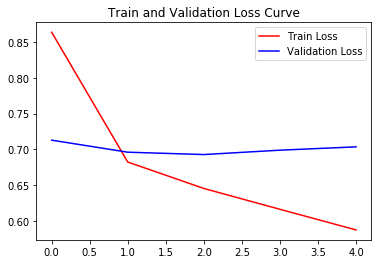

In [24]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.savefig("loss.png")
plt.show()

In [16]:
#save the model
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [28]:
# tf.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## EXTRACT EMBEDDING LAYERS AND MAPPING FOR VISUALIZATION IN TENSORFLOW EMBEDDING PROJECTOR

In [13]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]

In [14]:
book_em_weights.shape

(10001, 15)

In [15]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")
books_df_copy.head(2)

,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
book_id,,,,,,,,,,,,,,,,,,,,,
2767052,1,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
3,2,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [16]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)

In [17]:
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

## MAKING PREDICTIONS

In [24]:
book_arr = np.array(b_id)
user = np.array([53424 for i in range(len(b_id))])
pred = model.predict([book_arr, user])

In [25]:
pred

array([[4.548743 ],
       [4.448512 ],
       [3.5518723],
       ...,
       [4.528497 ],
       [4.5463295],
       [4.1157084]], dtype=float32)

In [26]:
pred = pred.reshape(-1)
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([7946, 5206,  861, 4867, 3627])

In [27]:
ratings_df.user_id.nunique()

53424

In [28]:
books_df.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
7946,7947,5031805,5031805,40769318,96,1433502410,9.781434e+12,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002.0,NaN,...,8953,10784,262,98,90,367,1152,9077,https://images.gr-assets.com/books/1410151002m...,https://images.gr-assets.com/books/1410151002s...
5206,5207,24818,24818,946589,28,836217357,9.780836e+12,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,...,19143,20374,228,114,149,942,3636,15533,https://images.gr-assets.com/books/1418211162m...,https://images.gr-assets.com/books/1418211162s...
861,862,17332218,17332218,16482835,34,765326361,9.780765e+12,Brandon Sanderson,2014.0,Words of Radiance,...,73572,108176,7261,154,404,2653,18272,86693,https://images.gr-assets.com/books/1391535251m...,https://images.gr-assets.com/books/1391535251s...
4867,4868,481749,481749,321161,115,875793266,9.780876e+12,James E. Talmage,1915.0,Jesus the Christ: A Study of the Messiah and H...,...,17179,18710,1066,354,241,926,2909,14280,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
3627,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,...,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...


### Prepare Data for use on application

In [127]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]

In [20]:
web_book_data = pd.read_csv("web_book_data.csv")

In [21]:
web_book_data = web_book_data.sort_values('book_id')

In [22]:
web_book_data.head()

,book_id,title,image_url,authors
26,1,Harry Potter and the Half-Blood Prince (Harry ...,https://images.gr-assets.com/books/1361039191m...,"J.K. Rowling, Mary GrandPré"
20,2,Harry Potter and the Order of the Phoenix (Har...,https://images.gr-assets.com/books/1387141547m...,"J.K. Rowling, Mary GrandPré"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
17,5,Harry Potter and the Prisoner of Azkaban (Harr...,https://images.gr-assets.com/books/1499277281m...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,6,Harry Potter and the Goblet of Fire (Harry Pot...,https://images.gr-assets.com/books/1361482611m...,"J.K. Rowling, Mary GrandPré"


In [23]:
web_book_data.to_json(r'web_book_data.json', orient='records')